In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!pip install torchvision torch faiss-cpu opencv-python-headless timm torchmetrics pytorch-metric-learning

In [4]:
import os
import glob
import random
import numpy as np
import torch
from types import SimpleNamespace

def set_seed(seed: int = 42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(True, warn_only=True)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark     = False
set_seed(42)


input_dirs = glob.glob('/kaggle/input/*flowers*')
if input_dirs:
    dataset_root = input_dirs[0]
else:
    dataset_root = '../input/flowers-recognition/flowers'

cfg = SimpleNamespace(
    seed=42,
    verbose=True,
    dataset=SimpleNamespace(
        root=dataset_root,
        image_size=224,
        num_workers=0
    ),
    splits=SimpleNamespace(
        training_ratio=0.8
    ),
    training=SimpleNamespace(
        batch_size=32,
        epochs=15,
        lr_backbone=1e-4,
        lr_head=1e-3
    ),
    index=SimpleNamespace(
        type='hnsw',
        metric='cosine',
        hnsw=SimpleNamespace(
            M=32,
            ef_construction=200,
            ef_search=50
        )
    ),
    models=[
        'resnet50',
        'efficientnet_b0',
        'clip_zeroshot',
        'clip_finetune',
        'metric_learning',
        'dinov2',
        ''
    ],
    evaluation=SimpleNamespace(
        k=5
    ),
    api=SimpleNamespace(
        host='0.0.0.0',
        port=8000
    )
)


In [5]:
from pathlib import Path
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random, os, torch, numpy as np

class FlowersDataset(Dataset):

    def __init__(self, root, transform=None):
        self.samples, self.labels = [], []
        classes = sorted(os.listdir(root))
        self.class_to_idx = {c:i for i,c in enumerate(classes)}
        for cls in classes:
            for p in Path(root, cls).glob('*'):
                self.samples.append(str(p))
                self.labels.append(self.class_to_idx[cls])
        self.transform = transform
        
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img = Image.open(self.samples[idx]).convert('RGB')
        if self.transform: img = self.transform(img)
        return img, self.labels[idx], self.samples[idx]


In [6]:
MEAN = (0.48145466, 0.4578275, 0.40821073)
STD  = (0.26862954, 0.26130258, 0.27577711)

clip_val_tf = transforms.Compose([
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

In [7]:
def set_seed(seed: int = 42):
    # 1 Python
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

    # 2 NumPy
    np.random.seed(seed)

    # 3 PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(True, warn_only=True)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark     = False

    # 4 FAISS (HNSW), sklearn, etc.
    try:
        import faiss
        faiss.rand.seed(seed)
    except ImportError:
        pass


In [8]:
full_ds = FlowersDataset("/kaggle/input/flowers-recognition/flowers", None)
idxs = list(range(len(full_ds)))
random.Random(42).shuffle(idxs)

from collections import defaultdict
cls_bins = defaultdict(list)
for i in idxs:
    cls_bins[full_ds.labels[i]].append(i)

train_idx, test_idx = [], []
for lst in cls_bins.values():
    cut = int(len(lst) * 0.8)
    train_idx += lst[:cut]
    test_idx  += lst[cut:]

train_set = torch.utils.data.Subset(full_ds, train_idx)
test_set  = torch.utils.data.Subset(full_ds, test_idx)
train_set.dataset.transform = clip_val_tf
test_set.dataset.transform  = clip_val_tf

In [9]:
import abc
class FeatureExtractor(abc.ABC):
    dim: int
    @abc.abstractmethod
    def fit(self, loader): pass
    @abc.abstractmethod
    def encode(self, images): pass

In [10]:
from copy import deepcopy

class FineTuneMixin:
    def _make_val_split(self, train_subset, val_ratio=1-cfg.splits.training_ratio):
        idx = train_subset.indices if hasattr(train_subset, "indices") else list(range(len(train_subset)))
        split = int(len(idx) * (1 - val_ratio))
        return (
            torch.utils.data.Subset(train_subset.dataset, idx[:split]),
            torch.utils.data.Subset(train_subset.dataset, idx[split:])
        )

    def _train_one_epoch(self, loader, criterion, optimizer, scheduler):
        self.backbone.train()
        running_loss, correct, total = 0.0, 0, 0
        for x, y, _ in tqdm(loader, disable=not cfg.verbose, leave=False):
            x, y = x.cuda(), y.cuda()
            optimizer.zero_grad()
            out = self.backbone(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            if scheduler: scheduler.step()

            running_loss += loss.item() * x.size(0)
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += x.size(0)
        return running_loss / total, correct / total

    @torch.no_grad()
    def _validate(self, loader, criterion):
        self.backbone.eval()
        vl, vc, vt = 0.0, 0, 0
        for x, y, _ in loader:
            x, y = x.cuda(), y.cuda()
            out = self.backbone(x)
            loss = criterion(out, y)
            vl += loss.item() * x.size(0)
            vc += (out.argmax(1) == y).sum().item()
            vt += x.size(0)
        return vl / vt, vc / vt

    def _fine_tune(self, train_loader, *, max_epochs=cfg.training.epochs, patience=3,
                   lr_head=cfg.training.lr_head, lr_base=cfg.training.lr_backbone, weight_decay=1e-4):
        train_ds, val_ds = self._make_val_split(train_loader.dataset, 0.1)
        train_dl = torch.utils.data.DataLoader(
            train_ds, batch_size=train_loader.batch_size, shuffle=True,
            num_workers=cfg.dataset.num_workers, drop_last=True)
        val_dl = torch.utils.data.DataLoader(
            val_ds, batch_size=train_loader.batch_size, shuffle=False,
            num_workers=cfg.dataset.num_workers)

        optim = torch.optim.AdamW(
            [
                {"params": self.head_params, "lr": lr_head, "weight_decay": weight_decay},
                {"params": self.base_params, "lr": lr_base, "weight_decay": weight_decay}
            ]
        )
        sched = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=max_epochs*len(train_dl))
        criterion = getattr(self, "loss_fn", nn.CrossEntropyLoss())
        best_wts, best_acc, wait = deepcopy(self.backbone.state_dict()), 0.0, 0

        for epoch in range(1, max_epochs + 1):
            tl, ta = self._train_one_epoch(train_dl, criterion, optim, sched)
            vl, va = self._validate(val_dl, criterion)
            print(f"Epoch {epoch:02d}: train loss={tl:.4f} acc={ta:.3f} | "
                  f"val loss={vl:.4f} acc={va:.3f}")
            if va > best_acc + 1e-4:
                best_acc, best_wts, wait = va, deepcopy(self.backbone.state_dict()), 0
            else:
                wait += 1
                if wait >= patience:
                    print("Early stopping triggered")
                    break

        self.backbone.load_state_dict(best_wts)
        print(f"Best val acc={best_acc:.3f} (epoch {epoch-wait})")

In [11]:
class ResNetExtractor(FineTuneMixin, FeatureExtractor):
    def __init__(self, num_classes=5):
        self.backbone = timm.create_model('resnet50', pretrained=True, drop_rate=0.2)
        self.backbone.reset_classifier(num_classes)
        self.dim = self.backbone.num_features

        classifier = self.backbone.get_classifier()
        self.head_params = list(classifier.parameters())
        self.base_params = [p for p in self.backbone.parameters() if id(p) not in set(map(id, self.head_params))]

    def fit(self, train_loader):
        print("Fine tune ResNet50")
        self.backbone.cuda()
        self._fine_tune(train_loader,
                        max_epochs=cfg.training.epochs,
                        patience=3,
                        lr_head=cfg.training.lr_head,
                        lr_base=cfg.training.lr_backbone)

    @staticmethod
    def _pool(feats):
        """
        B*C*H*W  ->  B*C или оставляет если уже
        """
        if feats.ndim == 4:
            feats = feats.mean(dim=(-1, -2))
        elif feats.ndim == 3:
            feats = feats.squeeze(-1)
        return torch.nn.functional.normalize(feats, dim=-1)

    @torch.no_grad()
    def encode(self, images):
        if isinstance(images, torch.Tensor):
            feats = self.backbone.forward_features(images.cuda())
            #print(feats.shape)
            feats = self._pool(feats)
            return feats.cpu().numpy().astype('float32')

In [12]:
class EfficientNetExtractor(FineTuneMixin, FeatureExtractor):
    def __init__(self, num_classes=5):
        self.backbone = timm.create_model(
            'efficientnet_b0',
            pretrained=True,
            drop_rate=0.2
        )
        self.backbone.reset_classifier(num_classes)
        self.dim = self.backbone.num_features
        classifier = self.backbone.get_classifier()
        self.head_params = list(classifier.parameters())
        self.base_params = [p for p in self.backbone.parameters()
                            if id(p) not in set(map(id, self.head_params))]

    def fit(self, train_loader):
        print("Fine tune EfficientNet-B0")
        self.backbone.cuda()
        self._fine_tune(train_loader,
                        max_epochs=cfg.training.epochs,
                        patience=3,
                        lr_head=cfg.training.lr_head,
                        lr_base=cfg.training.lr_backbone)
    @staticmethod
    def _pool(feats):
        """
        B*C*H*W  ->  B*C или оставляет если уже
        """
        if feats.ndim == 4:
            feats = feats.mean(dim=(-1, -2))
        elif feats.ndim == 3:
            feats = feats.squeeze(-1)
        return torch.nn.functional.normalize(feats, dim=-1)

    @torch.no_grad()
    def encode(self, images):
        if isinstance(images, torch.Tensor):
            feats = self.backbone.forward_features(images.cuda())
            #print(feats.shape)
            feats = self._pool(feats)
            return feats.cpu().numpy().astype('float32')

In [13]:
!pip install transformers accelerate scikit-learn

In [14]:
from transformers import CLIPProcessor, CLIPModel
class CLIPHFExtractor(FeatureExtractor):
    """
    CLIP ViT-B/32 по умолчанию без fine tune
    """
    def __init__(self,
                 model_name: str = "openai/clip-vit-base-patch32",
                 device: str = "cuda" if torch.cuda.is_available() else "cpu"):
        self.device = device
        self.processor = CLIPProcessor.from_pretrained(model_name)
        self.model     = CLIPModel.from_pretrained(model_name).to(device)
        self.model.eval()
        self.dim = self.model.config.projection_dim
        self.to_pil = transforms.ToPILImage()

    def fit(self, *_): pass

    @torch.no_grad()
    def encode(self, images):
        if isinstance(images, torch.Tensor):
            pil = [self.to_pil(img.cpu()) for img in images]
        else:
            pil = [Image.open(p).convert("RGB") for p in images]
        inputs = self.processor(images=pil, return_tensors="pt", padding=True).to(self.device)
        feats = self.model.get_image_features(**inputs)
        feats = F.normalize(feats, p=2, dim=-1)
        return feats.cpu().numpy().astype("float32")

2025-07-09 18:09:43.327369: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752084583.350261     238 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752084583.357327     238 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [15]:
!pip install pytorch_metric_learning

In [16]:
from pytorch_metric_learning import losses, miners, samplers
import torch.nn as nn


class MetricExtractor(nn.Module):
    """
    ResNet-18 backbone + Linear(256) + TripletLoss
    """
    def __init__(self, embed_dim: int = 256):
        super().__init__()
        self.backbone = timm.create_model(
            "resnet18", pretrained=True, num_classes=0, drop_rate=0.2
        )
        self.embed = nn.Linear(self.backbone.num_features, embed_dim)
        self.dim   = embed_dim

        self.loss_fn = losses.TripletMarginLoss(margin=0.2)
        self.miner   = miners.TripletMarginMiner(
            margin=0.2, type_of_triplets="semihard"
        )

    def fit(
        self,
        dl: DataLoader,
        *,
        epochs: int = cfg.training.epochs,
        patience: int = 4,
        lr_head: float = cfg.training.lr_head,
        lr_base: float = cfg.training.lr_backbone,
        weight_decay: float = 1e-4,
    ):
        idx = dl.dataset.indices if hasattr(dl.dataset, "indices") else range(len(dl.dataset))
        n_val = int(0.1 * len(idx))
        train_idx, val_idx = idx[:-n_val], idx[-n_val:]

        base_ds = dl.dataset.dataset if hasattr(dl.dataset, "dataset") else dl.dataset
        train_ds = Subset(base_ds, train_idx)
        val_ds   = Subset(base_ds, val_idx)

        train_dl = DataLoader(
            train_ds, batch_size=dl.batch_size, shuffle=True,
            num_workers=cfg.dataset.num_workers, drop_last=True
        )
        val_dl = DataLoader(
            val_ds, batch_size=dl.batch_size, shuffle=False,
            num_workers=cfg.dataset.num_workers
        )

        opt = torch.optim.AdamW(
            [
                {"params": self.embed.parameters(), "lr": lr_head, "weight_decay": weight_decay},
                {"params": self.backbone.parameters(), "lr": lr_base, "weight_decay": weight_decay},
            ]
        )
        sched = torch.optim.lr_scheduler.CosineAnnealingLR(
            opt, T_max=epochs * len(train_dl)
        )

        self.backbone.cuda(); self.embed.cuda()

        best_knn, wait = 0.0, 0
        best_state     = {k: v.clone() for k, v in self.state_dict().items()}

        for ep in range(1, epochs + 1):

            self.train()
            run_loss, seen = 0.0, 0
            for x, y, _ in tqdm(train_dl, leave=False, desc=f"E{ep:02d} train"):
                x, y = x.cuda(), y.cuda()
                opt.zero_grad()
                emb = F.normalize(self.embed(self.backbone(x)), dim=-1)
                hard = self.miner(emb, y)
                loss = self.loss_fn(emb, y, hard)
                loss.backward(); opt.step(); sched.step()
                run_loss += loss.item() * x.size(0)
                seen     += x.size(0)
            train_loss = run_loss / seen
            knn_acc = self._val_knn_acc(train_dl, val_dl, k=5)

            print(f"Epoch {ep:02d}: loss={train_loss:.4f} | val kNN@1={knn_acc:.3f}")

            if knn_acc > best_knn + 1e-4:
                best_knn, best_state, wait = knn_acc, \
                    {k: v.clone() for k, v in self.state_dict().items()}, 0
            else:
                wait += 1
                if wait >= patience:
                    print("Early stopping.")
                    break

        self.load_state_dict(best_state)
        print(f"Best val kNN@1 = {best_knn:.3f}")

    @torch.no_grad()
    def _val_knn_acc(self, train_dl: DataLoader, val_dl: DataLoader, *, k: int = 5) -> float:
        """
        Строит Flat-индекс из train-эмбеддингов и меряет top-1 точность на val
        """
        tr_vecs, tr_lbls = [], []
        for x, y, _ in train_dl:
            z = F.normalize(self.embed(self.backbone(x.cuda())), dim=-1)
            tr_vecs.append(z.cpu()); tr_lbls.append(y)
        tr_vecs = torch.cat(tr_vecs).numpy().astype("float32")
        tr_lbls = torch.cat(tr_lbls).numpy()

        faiss.normalize_L2(tr_vecs)
        index = faiss.IndexFlatIP(tr_vecs.shape[1])
        index.add(tr_vecs)

        correct, total = 0, 0
        for x, y, _ in val_dl:
            q = F.normalize(self.embed(self.backbone(x.cuda())), dim=-1).cpu().numpy()
            faiss.normalize_L2(q)
            _, I = index.search(q, k)                # (B,k)
            pred = tr_lbls[I[:, 0]]                  # ближайший сосед
            correct += np.sum(pred == y.numpy())
            total   += y.size(0)
        return correct / total

    @torch.no_grad()
    def encode(self, images):
        """Возвращает numpy (B,D)"""
        if isinstance(images, torch.Tensor):
            x = images.cuda()
        else:
            x = torch.stack([clip_val_tf(Image.open(p).convert("RGB")) for p in images]).cuda()

        z = F.normalize(self.embed(self.backbone(x)), dim=-1)
        return z.cpu().numpy().astype("float32")


In [17]:
class FastMetricExtractor(nn.Module):
    def __init__(self, embed_dim=512, n_classes=5):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.backbone = timm.create_model("resnet50", pretrained=True, num_classes=0)
        for name, p in self.backbone.named_parameters():
            if not name.startswith("layer4"):       
                p.requires_grad_(False)

        self.embed = nn.Linear(self.backbone.num_features, embed_dim)
        self.loss  = losses.ProxyAnchorLoss(n_classes, embed_dim).to(self.device)

    def forward(self, x):
        return self.backbone(x)


    def fit(self, dl: DataLoader, *, epochs=5, lr_backbone=1e-5, lr_head=1e-4):

        sampler = samplers.MPerClassSampler(dl.dataset, m=2,
                                            length_before_new_iter=len(dl.dataset))
        train_dl = DataLoader(dl.dataset,
                              batch_size = cfg.training.batch_size,
                              sampler    = sampler,
                              num_workers= cfg.dataset.num_workers,
                              drop_last  = True)


        opt = torch.optim.AdamW([
            {"params": self.embed.parameters(),                 "lr": lr_head},
            {"params": filter(lambda p: p.requires_grad,
                              self.backbone.parameters()),      "lr": lr_backbone},
            {"params": self.loss.parameters(),                  "lr": lr_head}
        ])

        self.to(self.device)
        best_map, best_state = 0., None

        for ep in range(1, epochs + 1):
            self.train()
            loop = tqdm(train_dl, total=len(train_dl),
                        desc=f"E{ep:02d} train", leave=False)

            for x, y, _ in loop:
                x, y = x.to(self.device), y.to(self.device)

                opt.zero_grad()
                emb  = F.normalize(self.embed(self.backbone(x)), dim=-1)
                loss = self.loss(emb, y)
                loss.backward()
                opt.step()

                loop.set_postfix(loss=f"{loss.item():.4f}")

    
            p5_val, map_val = self._quick_map(train_dl, k=5)
            print(f"E{ep:02d}: P@5={p5_val:.3f} | mAP@5={map_val:.3f}")

            if map_val > best_map:
                best_map, best_state = map_val, {k: v.clone()
                                                 for k, v in self.state_dict().items()}

        self.load_state_dict(best_state)
        print(f"✔ Best mAP={best_map:.3f}")


    @torch.no_grad()
    def _quick_map(self, dl, k: int = 5):
        vecs, lbls = [], []
        for x, y, _ in tqdm(dl, desc="encode val", leave=False):
            z = F.normalize(self.embed(self.backbone(x.to(self.device))), dim=-1).cpu()
            vecs.append(z); lbls.append(y)
        vecs = torch.cat(vecs).numpy().astype("float32")
        lbls = torch.cat(lbls).numpy()

        faiss.normalize_L2(vecs)
        index = faiss.IndexFlatIP(vecs.shape[1])
        if faiss.get_num_gpus():
            index = faiss.index_cpu_to_all_gpus(index)
        index.add(vecs)

        D, I = index.search(vecs, k)
        rel  = (lbls[I] == lbls[:, None]).astype(int)

        p_at_k = rel.sum(axis=1) / k
        mean_p = float(p_at_k.mean())

        precisions = rel.cumsum(1) / np.arange(1, k + 1)
        map_k = float((precisions * rel).sum() / rel.sum())

        return mean_p, map_k

    @torch.no_grad()
    def encode(self, x: torch.Tensor) -> np.ndarray:
        self.eval()
        x   = x.to(self.device, non_blocking=True)
        emb = F.normalize(self.embed(self.backbone(x)), dim=-1)
        return emb.cpu().numpy().astype("float32")

In [18]:
class _ClipImageEncoder(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.clip = clip_model

    def forward(self, x):                 # x: B*3*H*W
        return self.clip.get_image_features(pixel_values=x)


In [19]:
class _Wrapper:
    def __init__(self, loader, fn_map):
        self.loader = loader
        self.fn_map = fn_map
        self.batch_size = loader.batch_size
        self.dataset = loader.dataset
    def __iter__(self):
        return self.fn_map(self.loader)
    def __len__(self):
        return len(self.loader)

class CLIPFineTuneExtractor(FineTuneMixin, FeatureExtractor):
    def __init__(self, model_name="openai/clip-vit-base-patch32"):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        self.processor = CLIPProcessor.from_pretrained(model_name)
        self.clip      = CLIPModel.from_pretrained(model_name).to(self.device)
        self.dim       = self.clip.config.projection_dim
        self.head_params = list(self.clip.visual_projection.parameters())
        self.base_params = list(self.clip.vision_model.parameters())

        for p in self.clip.text_model.parameters():
            p.requires_grad = False

        self.backbone = _ClipImageEncoder(self.clip)
        self.t2pil    = transforms.ToPILImage()

    def fit(self, train_loader):
        print("Fine tune CLIP")

        def _tensor_loader(dl):
            for x, y, pths in dl:
                pil = [self.t2pil(img.cpu()) for img in x]
                px  = self.processor(images=pil, return_tensors="pt", padding=True)["pixel_values"]
                yield px, y, pths

        wrapped = _Wrapper(train_loader, _tensor_loader)
        self.clip.train()
        self._fine_tune(
            wrapped,
            max_epochs=cfg.training.epochs,
            patience=2,
            lr_head=cfg.training.lr_head,
            lr_base=cfg.training.lr_backbone
        )

    @torch.no_grad()
    def encode(self, images):
        if isinstance(images, torch.Tensor):
            pil = [self.t2pil(img.cpu()) for img in images]
        else:
            pil = [Image.open(p).convert("RGB") for p in images]

        px = self.processor(images=pil, return_tensors="pt", padding=True)["pixel_values"].to(self.device)
        feats = self.clip.get_image_features(pixel_values=px)
        return F.normalize(feats, p=2, dim=-1).cpu().numpy().astype("float32")

In [20]:
class DINOv2Extractor(FeatureExtractor):
    def __init__(self, model_name: str = "vit_base_patch14_dinov2"):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.IMG = 518
        self.backbone = timm.create_model(
            model_name,
            pretrained=True,
            num_classes=0,
            img_size=self.IMG,          # задаём правильный размер тк дино на 518
        ).to(self.device).eval()

        self.dim = self.backbone.num_features

        self.tf = transforms.Compose([
            transforms.Resize(self.IMG, interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.CenterCrop(self.IMG),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                 std=(0.229, 0.224, 0.225)),
        ])

    def fit(self, *_): 
        pass

    @torch.no_grad()
    def encode(self, images):
        if isinstance(images, torch.Tensor):
            x = images.to(self.device)
            if x.shape[-1] != self.IMG:
                x = F.interpolate(x, size=self.IMG, mode="bicubic", align_corners=False)
        else:
            x = torch.stack([self.tf(Image.open(p).convert("RGB")) for p in images]).to(self.device)

        feats = self.backbone(x)            # B * 768
        feats = F.normalize(feats, dim=-1)
        return feats.cpu().numpy().astype("float32")

In [21]:
!pip install faiss-cpu

In [22]:
import faiss


def build_index(vecs: np.ndarray, metric: str = "cosine") -> faiss.Index:
    """
    vecs – (N,D) float32,
    metric: 'cosine' | 'l2'
    """
    vecs = np.ascontiguousarray(vecs, dtype="float32")

    if metric == "cosine":
        faiss.normalize_L2(vecs)
        index = faiss.IndexFlatIP(vecs.shape[1])
    elif metric == "l2":
        index = faiss.IndexFlatL2(vecs.shape[1])
    else:
        raise ValueError("метрика должна быть 'cosine' or 'l2'")

    index.add(vecs)
    return index

In [24]:
from tqdm.auto import tqdm
from sklearn.metrics import average_precision_score

def evaluate(extractor, train_loader, test_loader):
    """
    → Precision@5, mAP, faiss-index, rel_paths
    """
    extractor.fit(train_loader)

    enc_loader = DataLoader(
        train_loader.dataset,
        batch_size=train_loader.batch_size,
        shuffle=False,
        num_workers=cfg.dataset.num_workers,
    )

    db_vecs, db_labels, rel_paths = [], [], []
    for x, y, paths in enc_loader:
        db_vecs.append(extractor.encode(x))
        db_labels.extend(y.numpy())
        rel_paths.extend([os.path.relpath(p, cfg.dataset.root) for p in paths])

    db_vecs   = np.vstack(db_vecs).astype("float32")
    db_labels = np.asarray(db_labels)

    if cfg.index.metric == "cosine":
        faiss.normalize_L2(db_vecs)
        index = faiss.IndexFlatIP(db_vecs.shape[1])
    else:
        index = faiss.IndexFlatL2(db_vecs.shape[1])
    index.add(db_vecs)

    k = cfg.evaluation.k
    prec_sum, ap_list = 0.0, []
    for x, y, _ in test_loader:
        q = extractor.encode(x)
        if cfg.index.metric == "cosine":
            faiss.normalize_L2(q)
        D, I = index.search(q, db_vecs.shape[0])  
        for lbl, d_row, i_row in zip(y.numpy(), D, I):
            prec_sum += np.sum(db_labels[i_row[:k]] == lbl) / k
            rel = (db_labels[i_row] == lbl).astype(int)
            score = d_row if cfg.index.metric != "l2" else -d_row
            ap_list.append(average_precision_score(rel, score))

    precision = prec_sum / len(test_loader.dataset)
    mAP = float(np.mean(ap_list))
    return precision, mAP, index, rel_paths

In [25]:
from collections import Counter
from pathlib import Path
from datetime import datetime
import torch.nn.functional as F
from torch.utils.data import Subset
import math

import timm

extractors = {
    # 'resnet50'      : ResNetExtractor(),
    # 'efficientnet_b0': EfficientNetExtractor(),
    # 'clip_zeroshot' : CLIPHFExtractor(),
    # 'clip_finetune' : CLIPFineTuneExtractor(),
    # 'dinov2'        : DINOv2Extractor(),
    'metric_learning' : FastMetricExtractor()
}

train_loader = DataLoader(train_set, batch_size=cfg.training.batch_size, 
                          shuffle=False, num_workers=cfg.dataset.num_workers, drop_last=True)
test_loader  = DataLoader(test_set,  batch_size=cfg.training.batch_size, 
                          shuffle=False, num_workers=cfg.dataset.num_workers)
save_dir = Path("checkpoints")
save_dir.mkdir(exist_ok=True, parents=True)
scores = {}
for name, extractor in extractors.items():
    print(f"\n=== {name.upper()} ===")
    p, mAP, idx, rel_paths = evaluate(extractor, train_loader, test_loader)
    scores[name] = (p, mAP)
    print(f"Precision@{cfg.evaluation.k}: {p:.3f}")
    print(f"mAP@{cfg.evaluation.k}: {mAP:.3f}")
    stamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    base  = f"{name}_{stamp}"

    if hasattr(extractor, "state_dict"):
        torch.save(extractor.state_dict(), save_dir / f"{base}.pth")
    elif hasattr(extractor, "backbone") and hasattr(extractor.backbone, "state_dict"):
        torch.save(extractor.backbone.state_dict(), save_dir / f"{base}.pth")

    faiss.write_index(idx, str(save_dir / f"{base}.faiss"))
    np.save(save_dir / f"{base}_paths.npy", np.array(rel_paths, dtype=object))
    print(f"Saved: {base}.pth / .faiss / _paths.npy")


=== METRIC_LEARNING ===


E01 train:   0%|          | 0/107 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_metric_learning/distances/dot_product_similarity.py:12: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  return torch.matmul(query_emb, ref_emb.t())
/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not

encode val:   0%|          | 0/107 [00:00<?, ?it/s]

E01: P@5=0.920 | mAP@5=0.995


E02 train:   0%|          | 0/107 [00:00<?, ?it/s]

encode val:   0%|          | 0/107 [00:00<?, ?it/s]

E02: P@5=0.934 | mAP@5=0.996


E03 train:   0%|          | 0/107 [00:00<?, ?it/s]

encode val:   0%|          | 0/107 [00:00<?, ?it/s]

E03: P@5=0.944 | mAP@5=0.997


E04 train:   0%|          | 0/107 [00:00<?, ?it/s]

encode val:   0%|          | 0/107 [00:00<?, ?it/s]

E04: P@5=0.960 | mAP@5=0.997


E05 train:   0%|          | 0/107 [00:00<?, ?it/s]

encode val:   0%|          | 0/107 [00:00<?, ?it/s]

E05: P@5=0.961 | mAP@5=0.998
✔ Best mAP=0.998
Precision@5: 0.910
mAP@5: 0.856
Saved: metric_learning_20250709_181847.pth / .faiss / _paths.npy


In [27]:
import torchvision.transforms as T
import torchvision
import matplotlib.pyplot as plt
device = "cuda"
ROOT = Path('/kaggle/input/resnet50/pytorch/default/1')
WEIGHTS_PATH = ROOT / 'resnet50_20250709_131618.pth'     
PATHS_NPY    = ROOT / 'resnet50_20250709_131618_paths.npy' 
FAISS_INDEX  = ROOT / 'resnet50_20250709_131618.faiss'     
DATASET_ROOT = Path('/kaggle/input/flowers-recognition')
_rn50 = torchvision.models.resnet50(weights=None)

state_dict = torch.load(WEIGHTS_PATH, map_location='cpu')


for key in ['fc.weight', 'fc.bias']:
    state_dict.pop(key, None)

_rn50.load_state_dict(state_dict, strict=False)

feature_extractor = torch.nn.Sequential(*list(_rn50.children())[:-1]).to(device).eval()

_preprocess = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std =[0.229, 0.224, 0.225]),
])

def _embed_image(img_path: Path) -> torch.Tensor:
    img = Image.open(img_path).convert('RGB')
    t = _preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        emb = feature_extractor(t).squeeze().cpu()
    return emb

# --- 4. Индекс + пути ---
raw_paths = np.load(PATHS_NPY, allow_pickle=True) 
dataset_paths = np.array([
    (DATASET_ROOT / p).resolve() if not Path(p).is_absolute() else Path(p)
    for p in raw_paths
], dtype=str)

index = faiss.read_index(str(FAISS_INDEX))

def _normalize(v: np.ndarray):
    v /= (np.linalg.norm(v) + 1e-12)
    return v

def find_similar_faiss(query_path: str | Path, topk: int = 5):
    """Возвращает (path, similarity) из уже построенного FAISS-индекса."""
    emb = _embed_image(Path(query_path)).numpy().astype('float32')
    emb = _normalize(emb)                                  
    D, I = index.search(emb[None, :], topk)               
    sims = 1 - D[0] if index.metric_type == faiss.METRIC_L2 else D[0]
    return [(str(dataset_paths[i]), float(sims[j])) for j, i in enumerate(I[0])]

def show_results(query_path: str | Path, topk: int = 5):
    res = find_similar_faiss(query_path, topk)
    fig, axes = plt.subplots(1, topk + 1, figsize=(3*(topk+1), 3))
    axes[0].imshow(Image.open(query_path).convert('RGB'))
    axes[0].set_title('Query')
    axes[0].axis('off')
    for idx, (p, s) in enumerate(res, 1):
        axes[idx].imshow(Image.open(p).convert('RGB'))
        axes[idx].set_title(f'{s:.3f}')
        axes[idx].axis('off')
    plt.tight_layout(); plt.show()

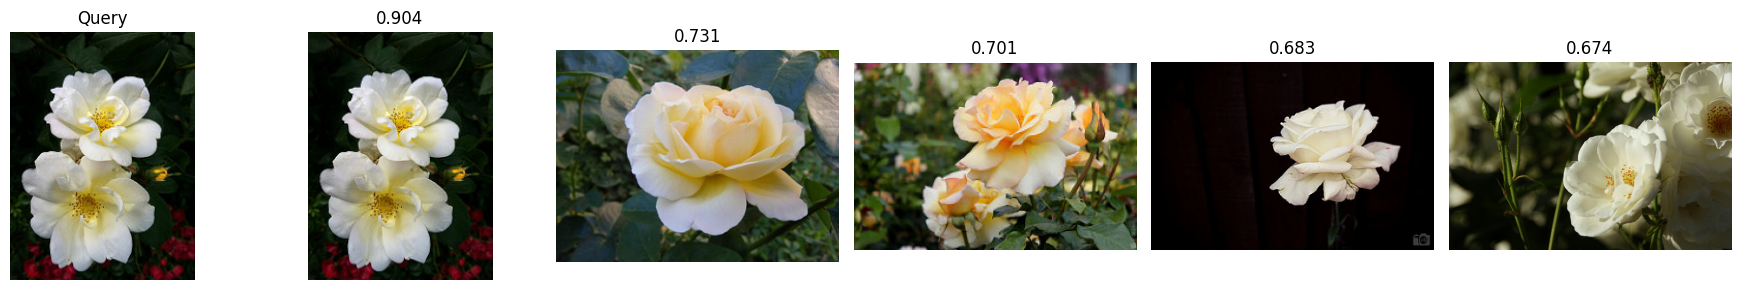

In [28]:
show_results("/kaggle/input/flowers-recognition/flowers/rose/10090824183_d02c613f10_m.jpg")

In [ ]:
# best_name = max(scores, key=scores.get)
# extr = extractors[best_name]
# extr.fit(train_loader)


# all_paths = [s for _,_,paths in DataLoader(full_ds, batch_size=128) for s in paths]
# all_feats=[]
# for x,_,_ in DataLoader(full_ds, batch_size=128):
#     all_feats.append(extr.encode(x))
# all_feats = np.vstack(all_feats)
# index = build_index(all_feats, cfg.index.metric)
# faiss.write_index(index, f'{best_name}.faiss')

# # веса модели (если DL)
# torch.save(extr.backbone.state_dict(), f'{best_name}.pth')
# np.save('paths.npy', np.array(all_paths))


In [26]:
!zip -r /kaggle/working/output.zip /kaggle/working/

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/.ipynb_checkpoints/ (stored 0%)
  adding: kaggle/working/checkpoints/ (stored 0%)
  adding: kaggle/working/checkpoints/metric_learning_20250709_181847_paths.npy (deflated 66%)
  adding: kaggle/working/checkpoints/metric_learning_20250709_181847.faiss (deflated 7%)
  adding: kaggle/working/checkpoints/metric_learning_20250709_181847.pth (deflated 7%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
